## Problem: Detection of aggressive tweets

Training dataset has 16000 tweets (in english) which are labeled (by human) as:
* 1 (Cyber-Aggressive; 9714 items)
* 0 (Non Cyber-Aggressive; 6286 items)

# Classification of Tweets

### Dividing data into the training and test part

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_json('./Data/train.json')

In [3]:
X = data.content
y = data.label

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)

### Advanced Preprocessing

In [181]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

In [136]:
def plot_confusion_matrix(y_true, y_pred):
    conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred) / len(y_true)
    
    fig, ax = plt.subplots(figsize=(3, 3))    
    ax.matshow(conf_mat, cmap=plt.cm.Greens, alpha=0.5)
    
    labels = np.unique(y_true)
    for i, j in itertools.product(labels, repeat=len(labels)):
        ax.annotate(s='%.2f' % conf_mat[i, j], xy=(j, i), va='center', ha='center')
        
    ax.set_xlabel('Predicted label', size=14)
    ax.set_ylabel('Real label', size=14)
    plt.show()

In [182]:
from sklearn.base import TransformerMixin
import nltk
import string
import re

In [199]:
class AdvancedTextPreprocessor(TransformerMixin):
    
    def __init__(self, stopwords=[], punctuation=''):
        self.stopwords = set(stopwords)
        self.punctuation = set(punctuation)
    
    def fit(self, X, y=None):
        return self
    
    def get_happy_emoticons(self, X, normalize=False):
        # happy face or heart
        regex = '[:;=8x]-?[)D\\]*]|<3'
        emoticons = [' '.join(re.findall(regex, doc)) for doc in X]
        
        # normalize happy faces --> :)
        if normalize:
            emoticons = [re.sub('[;=8x]', ':', doc) for doc in emoticons]
            emoticons = [re.sub('[D\\]*]', ')', doc) for doc in emoticons]
            emoticons = [re.sub('-', '', doc) for doc in emoticons]
            
        return emoticons

    def get_question_marks(self, X):
        # one or more question marks
        regex = '\\?{1,}'
        question_marks = [' '.join(re.findall(regex, doc)) for doc in X]
        return question_marks
    
    def transform(self, X):
        stemmer = nltk.PorterStemmer()
        
        # keep happy faces and hearts
        emoticons = self.get_happy_emoticons(X)
        # keep one or more question marks
        question_marks = self.get_question_marks(X)
        
        # convert to lowercase
        X_lower = [doc.lower() for doc in X]
        # split texts into words
        X_tokenized = [nltk.word_tokenize(doc) for doc in X_lower]
        # remove punctuation and stopwords
        X_cleaned = [[token for token in doc_tokenized 
                      if token not in self.punctuation and token not in self.stopwords]
                    for doc_tokenized in X_tokenized]
        # leave stems of words
        X_stemmed = [[stemmer.stem(token) for token in doc_tokenized]
                    for doc_tokenized in X_cleaned]
        # join list of stems, emoticons and question marks
        X_preprocessed = [' '.join(doc_tokenized + [emoticons[i], question_marks[i]])
                          for i, doc_tokenized in enumerate(X_stemmed)]
        
        return X_preprocessed

In [183]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

In [212]:
IRRELEVANT_STOPWORDS = pd.read_csv('./Data/irrelevant_stopwords.csv', header=None).T.values[0]
PUNCTUATION = string.punctuation

In [207]:
emoticon_regex = '[:;=8x]-?[)D\\]*]|<3'
question_mark_regex = '\\?{1,}'
advanced_token_pattern = '|'.join(['(?u)\\b'+ emoticon_regex, question_mark_regex, '\\w{2,}\\b'])

pipe_advanced_baseline = Pipeline([
                ('preprocessor', AdvancedTextPreprocessor(stopwords=IRRELEVANT_STOPWORDS, 
                                                          punctuation=PUNCTUATION)),
                ('vectorizer', CountVectorizer(token_pattern=advanced_token_pattern)),
                ('scaler', MaxAbsScaler()),
                ('clf', LogisticRegression(penalty='l2', C=1.0))
                ])

In [208]:
pipe_advanced_baseline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preprocessor', <__main__.AdvancedTextPreprocessor object at 0x0000024320996550>), ('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=Non...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [209]:
y_train_pred = pipe_advanced_baseline.predict(X_train)
y_test_pred = pipe_advanced_baseline.predict(X_test)

Slight improvement (baseline model: accuracy = 0.792)

In [210]:
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.907
Test dataset: accuracy = 0.799


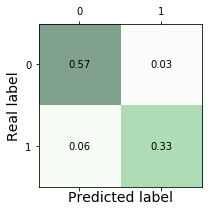

In [211]:
plot_confusion_matrix(y_train, y_train_pred)